# Prototype Aus-wide saltmarsh

In [9]:
# load imports/set up
%run 'saltmarsh_prototype_imports.ipynb'

ncpus = 15


## Classification

- for the moment focusing on predicting to image chips
- eventually this will be either chips or full coastline runs
- also eventually multi-temporal, based on corrsponding tmeporally-relevant models

In [ ]:
### Set up the DASK cluster

In [3]:
create_local_dask_cluster(spare_mem='2Gb')

Client Scheduler: tcp://127.0.0.1:35975 Dashboard: /user/mitchest/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 14.11 GB


In [ ]:
### Model & classification setup

In [2]:
wetland_model_path = 'models/prelim_wetland_model.joblib'
ecosystem_model_path = 'models/prelim_ecosystem_model.joblib'

testing_locations = {
    'French Is': (-38.3037, 145.2880),
    'Dharug Mangrove Ck': (-33.41415, 151.14825),
    'Moreton Is': (-27.3355, 153.4151),
    'Dinah Is': (-16.38087, 141.38947),
}

buffer = 0.02 # buffer distance in degrees around test locations for image chips; 0.01 ~ 1km = 2km x 2km chip

dask_chunks = {'x': 1000, 'y': 1000} # size in pixels of dask chunks (testing locaitons will be within one chunk)

results = 'outputs/'

### Import the models

In [3]:
wetland_model = joblib.load(wetland_model_path)
ecosystem_model = joblib.load(ecosystem_model_path)

### Setup the classification query

In [4]:
# Set up our inputs for the covaraite calculations
time = ("2019-01-01", "2020-12-31")
zonal_stats = None
return_coords = False # for now

# Set up the data cube inputs
measurements = ['nbart_coastal_aerosol', 'nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1']
resolution = (-30, 30)
output_crs = 'epsg:3577'

# Generate a new datacube query object
query = {
    'time': time,
    'measurements': measurements,
    'resolution': resolution,
    'output_crs': output_crs,
}

### Define the feature layers/covariates

In [5]:
def feature_layers(query):
    #connect to the datacube
    dc = datacube.Datacube(app='aust_saltmarsh')
    
    #load ls8 data
    ds = dc.load(product='ga_ls8c_ard_3',
                 #dask_chunks=dask_chunks, #add dask chunks
                 **query,)
    
    # add reflectance medians
    ref_med = ds.median('time')
    
    # Add reflectance variance metrics
    ref_sdev = ds.std('time')
    ref_sdev_names = dict(zip(list(ref_sdev.keys()), [x + '_std' for x in list(ref_sdev.keys())]))
    ref_sdev = ref_sdev.rename_vars(name_dict=ref_sdev_names)
    
    # Calculate relevant band indices
    indices = calculate_indices(ref_med,
                                index=['NDVI', 'NDWI'], # add others later
                                drop=True,
                                collection='ga_ls_3')
    '''
    more things to add:
    - merged land DEM/intertidal DEM/ocean bathymetry
    - slope
    - temperature
    '''
      
    # Merge results into single dataset 
    result = xr.merge([ref_med, ref_sdev, indices], compat='override')
    
    return result

### Loop through the test locations and predict the models

#### Wetland probability

In [6]:
wetland_predictions = []

for key, value in testing_locations.items():

    print('working on: ' + key)
    
    bounds = {'x': (value[1] - buffer, value[1] + buffer),
    'y': (value[0] + buffer, value[0] - buffer)}
    
    # Update datacube query

    query.update(bounds)

    # Load data and calculate features
    data = feature_layers(query).squeeze()

    # Predict using the imported model
    wetland_predicted = predict_xr(wetland_model,
                           data,
                           proba=True,
                           persist=True,
                           clean=True,
                           return_input=True).compute()

    wetland_predictions.append(wetland_predicted)

working on: French Is
Dropping bands ['nbart_coastal_aerosol', 'nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1']
predicting...
   probabilities...
   input features...
working on: Dharug Mangrove Ck
Dropping bands ['nbart_coastal_aerosol', 'nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1']
predicting...
   probabilities...
   input features...
working on: Moreton Is
Dropping bands ['nbart_coastal_aerosol', 'nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1']
predicting...
   probabilities...
   input features...
working on: Dinah Is
Dropping bands ['nbart_coastal_aerosol', 'nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1']
predicting...
   probabilities...
   input features...


#### Plot the wetland chips

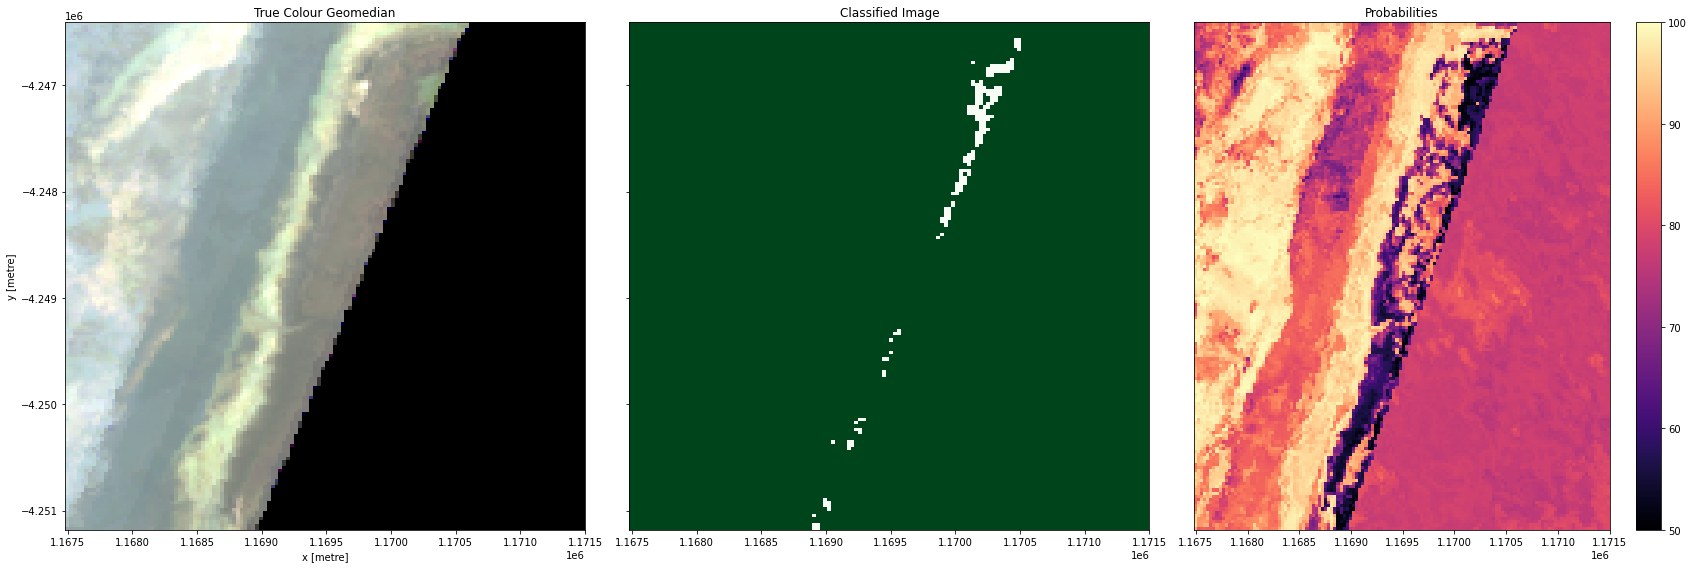

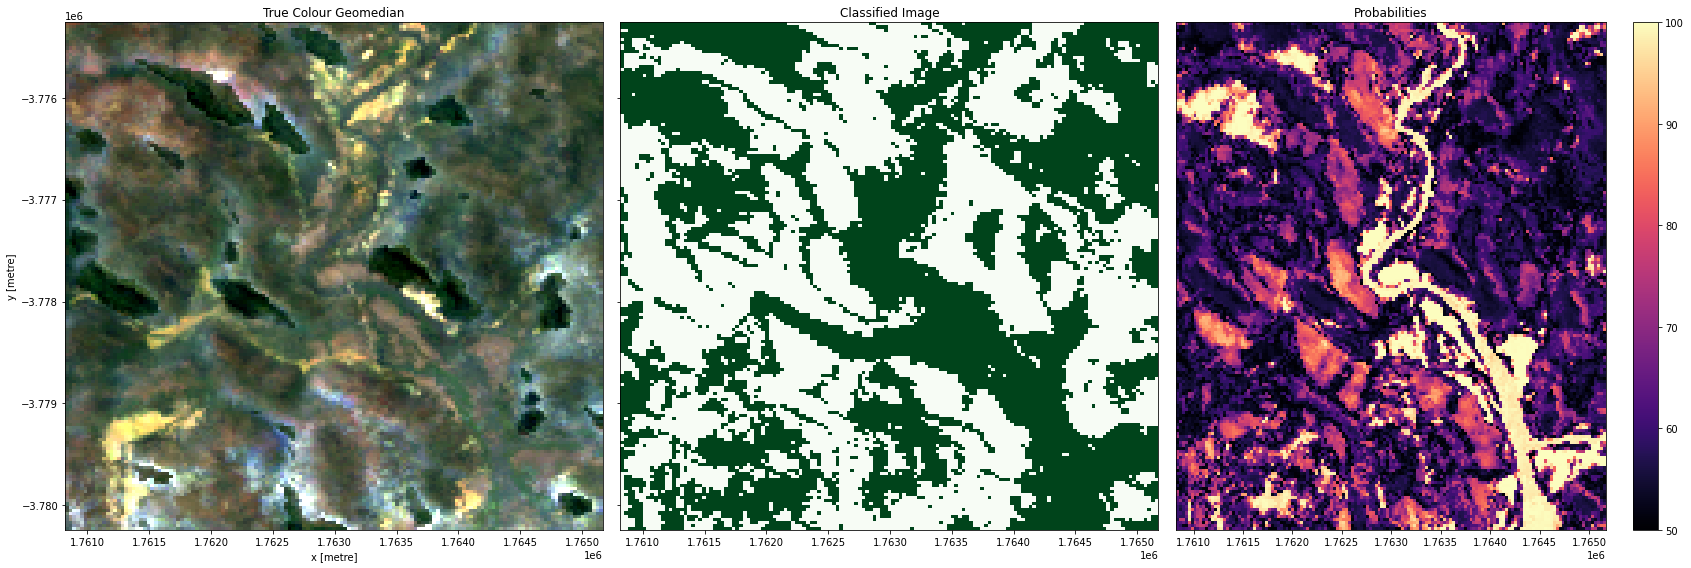

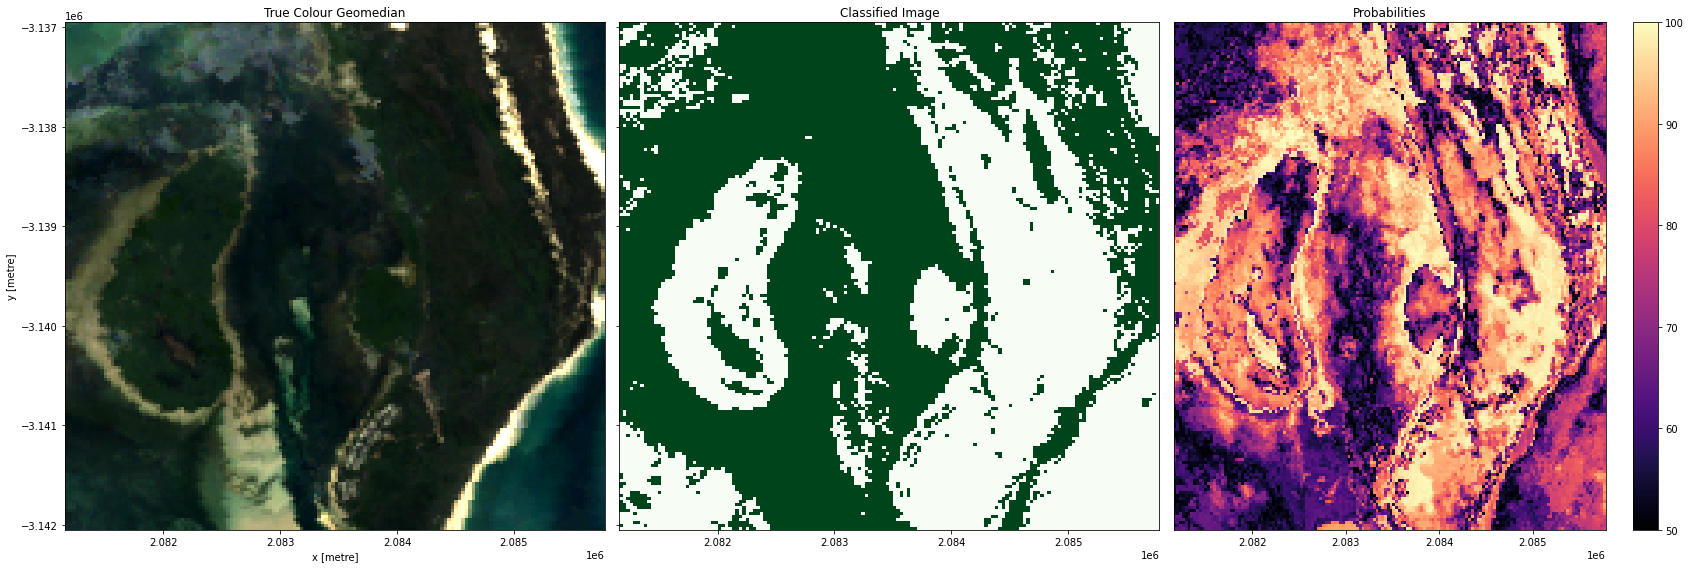

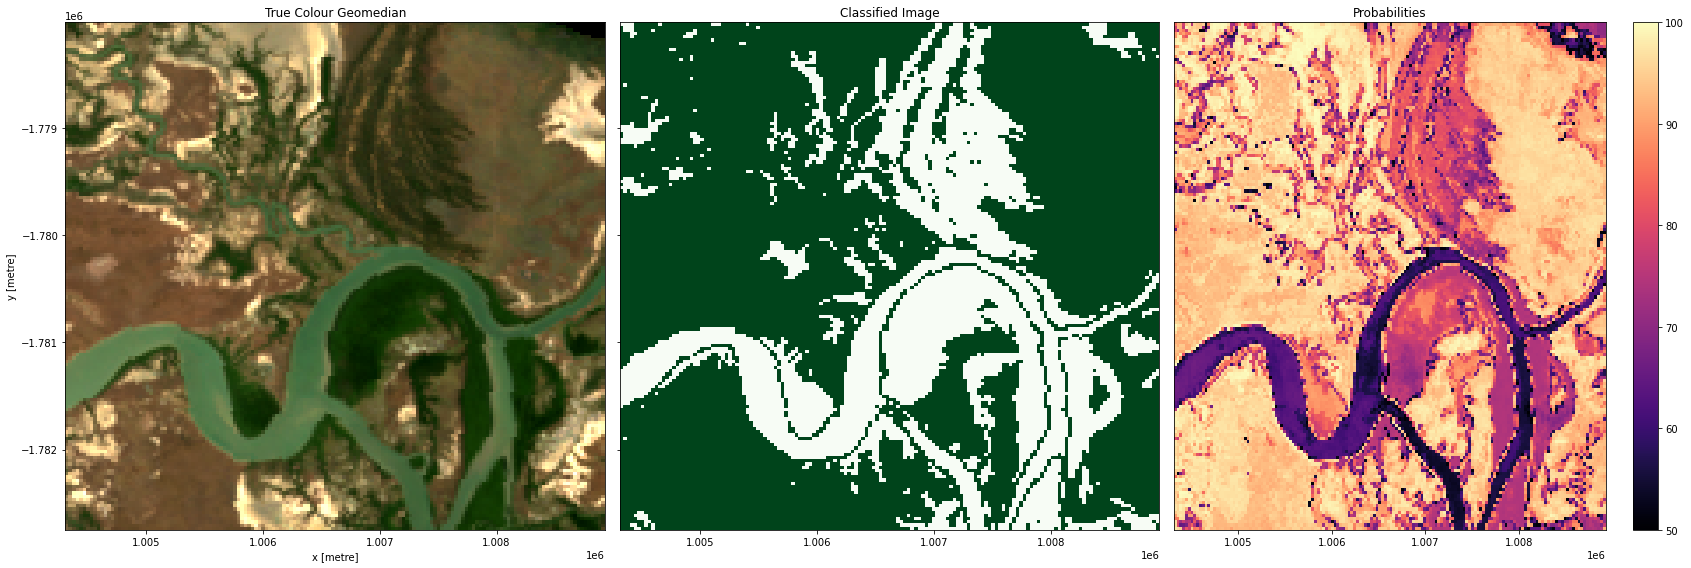

In [7]:
for i in range(0, len(wetland_predictions)):
    fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharey=True)

    # Plot true colour image
    rgb(wetland_predictions[i],
        bands=['nbart_red', 'nbart_green', 'nbart_blue'],
        ax=axes[0],
        percentile_stretch=(0.01, 0.99))

    # Plot classified image
    wetland_predictions[i].Predictions.plot(ax=axes[1],
                                    cmap='Greens',
                                    add_labels=False,
                                    add_colorbar=False)

    wetland_predictions[i].Probabilities.plot(ax=axes[2],
                                      cmap='magma',
                                      vmin=50,
                                      vmax=100,
                                      add_labels=False,
                                      add_colorbar=True)

    # Remove axis on right plot
    axes[2].get_yaxis().set_visible(False)

    # Add plot titles
    axes[0].set_title('True Colour Geomedian')
    axes[1].set_title('Classified Image')
    axes[2].set_title('Probabilities')
    plt.tight_layout();

#### Ecosystem classification

In [8]:
ecosystem_predictions = []

for key, value in testing_locations.items():

    print('working on: ' + key)
    
    bounds = {'x': (value[1] - buffer, value[1] + buffer),
    'y': (value[0] + buffer, value[0] - buffer)}
    
    # Update datacube query

    query.update(bounds)

    # Load data and calculate features
    data = feature_layers(query).squeeze()

    # Predict using the imported model
    ecosystem_predicted = predict_xr(ecosystem_model,
                           data,
                           proba=False,
                           persist=True,
                           clean=True,
                           return_input=True).compute()

    ecosystem_predictions.append(ecosystem_predicted)

working on: French Is
Dropping bands ['nbart_coastal_aerosol', 'nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1']
predicting...
   input features...
working on: Dharug Mangrove Ck
Dropping bands ['nbart_coastal_aerosol', 'nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1']
predicting...
   input features...
working on: Moreton Is
Dropping bands ['nbart_coastal_aerosol', 'nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1']
predicting...
   input features...
working on: Dinah Is
Dropping bands ['nbart_coastal_aerosol', 'nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1']
predicting...
   input features...


#### Plot the ecosystem chips

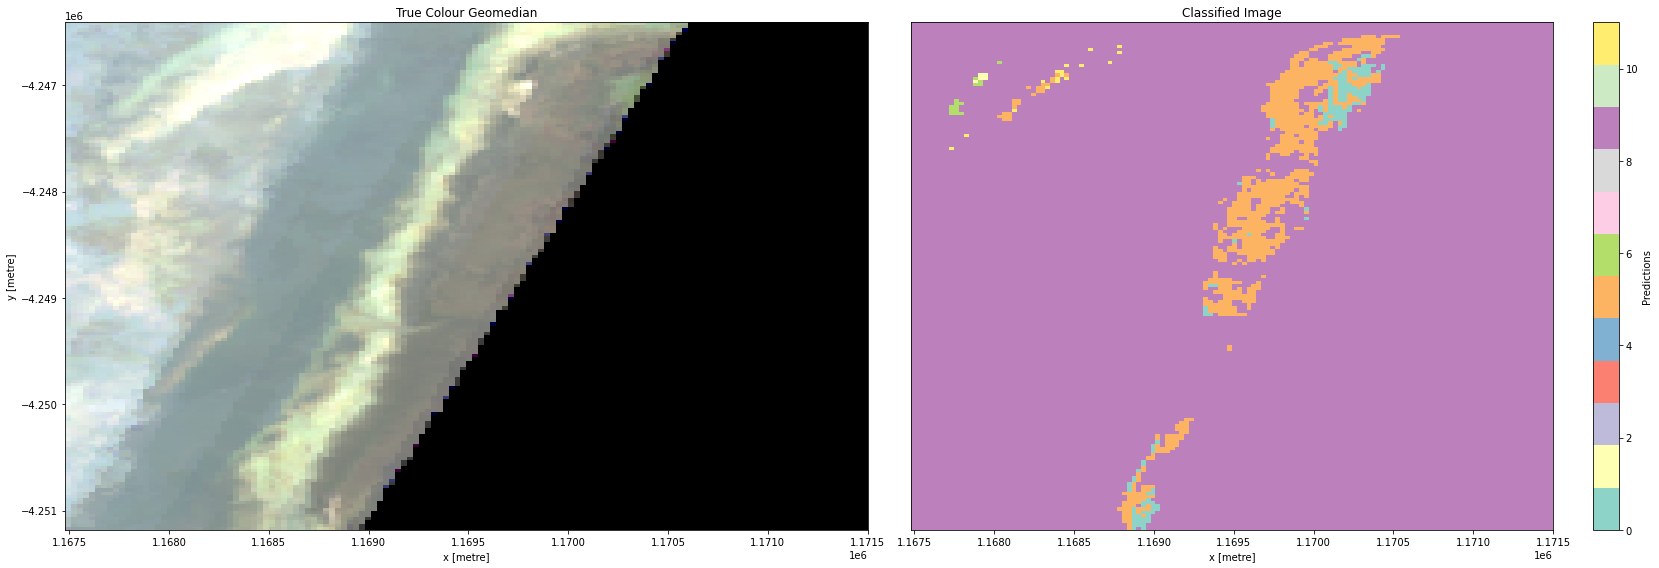

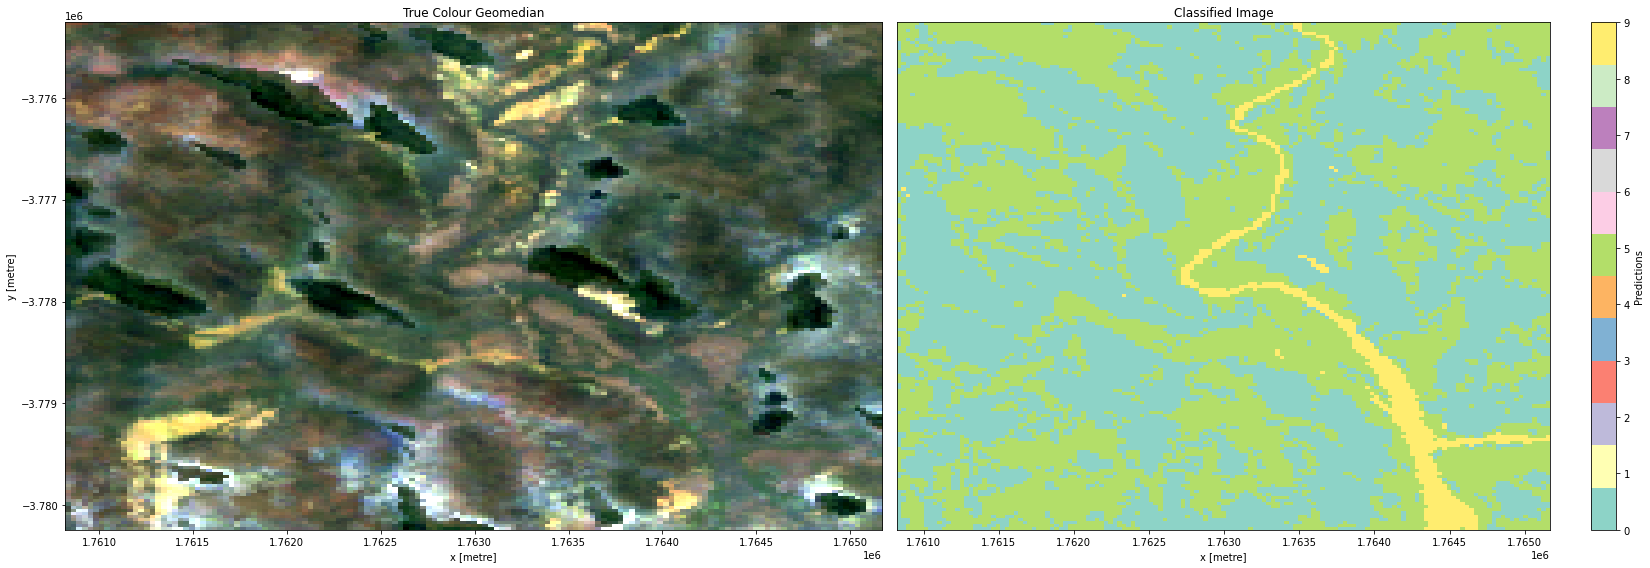

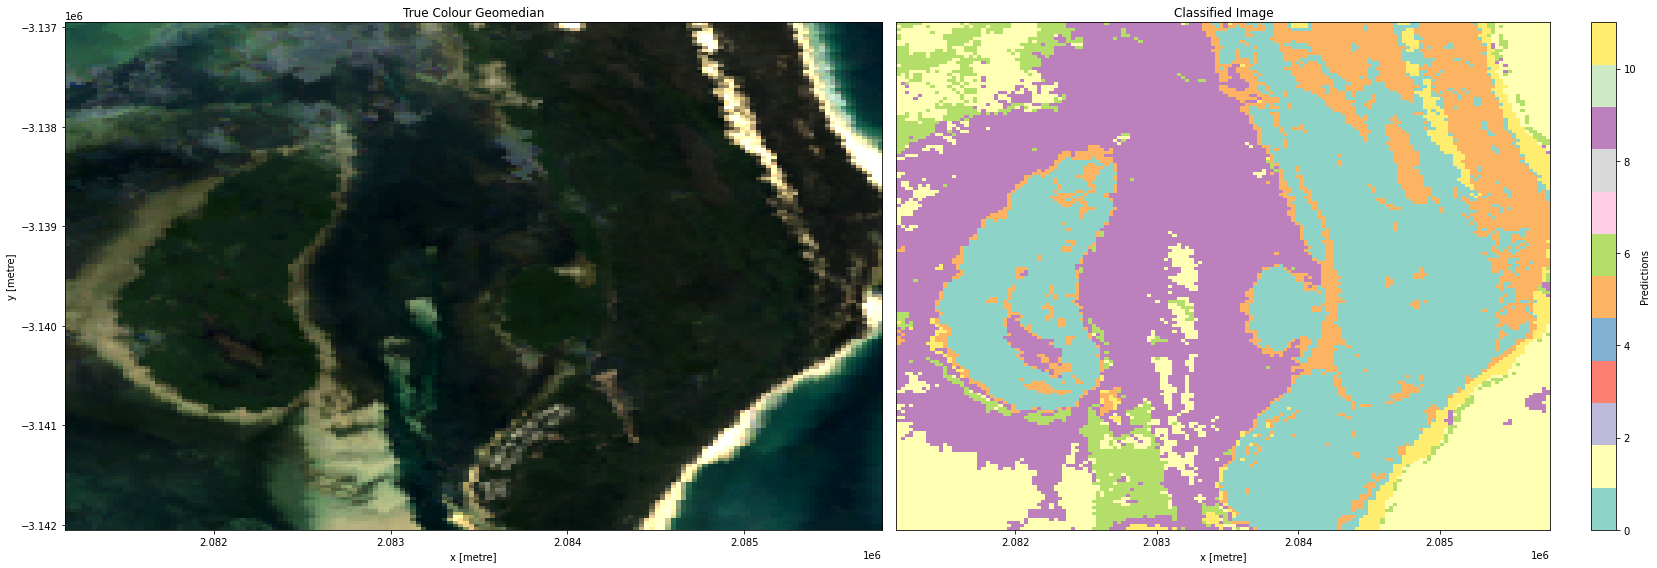

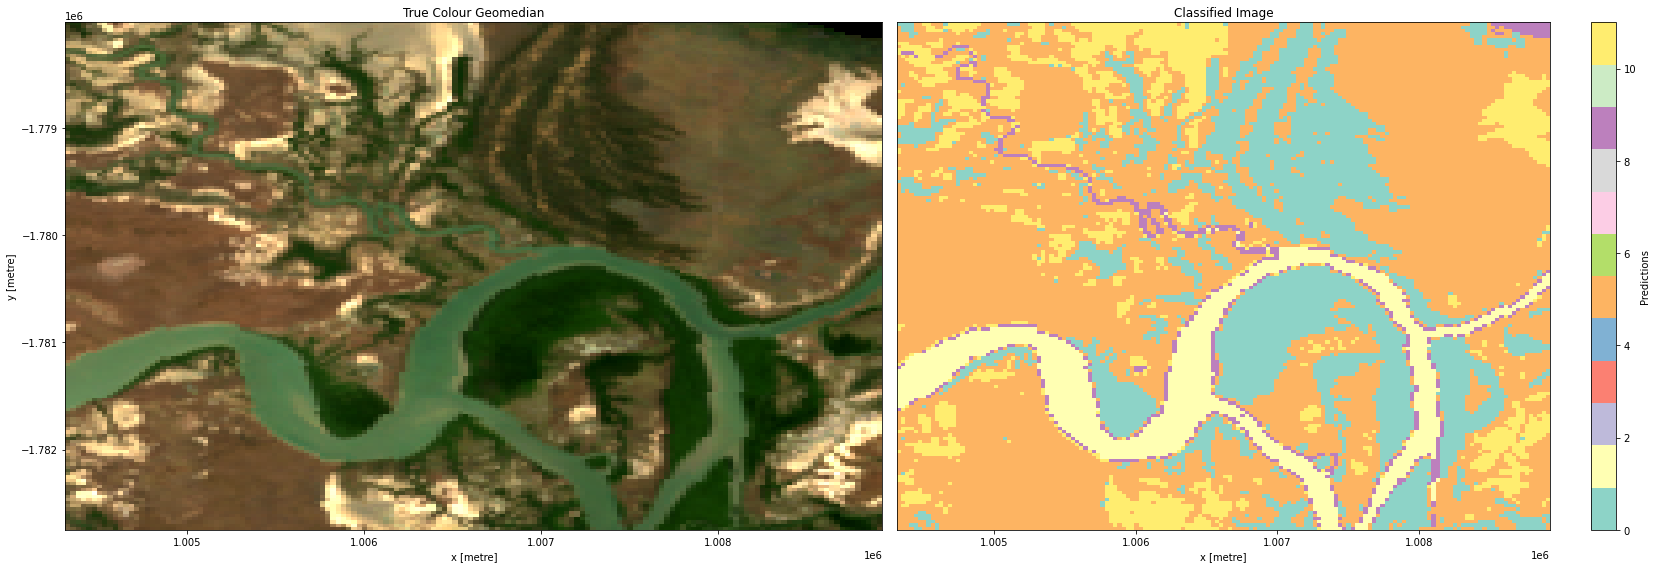

In [10]:
for i in range(0, len(ecosystem_predictions)):
    fig, axes = plt.subplots(1, 2, figsize=(24, 8), sharey=True)

    # Plot true colour image
    rgb(ecosystem_predictions[i],
        bands=['nbart_red', 'nbart_green', 'nbart_blue'],
        ax=axes[0],
        percentile_stretch=(0.01, 0.99))

    # Plot classified image
    ecosystem_predictions[i].Predictions.plot(ax=axes[1],
                                    cmap='Set3',
                                    add_labels=True,
                                    add_colorbar=True)

    # Remove axis on right plot
    axes[1].get_yaxis().set_visible(False)

    # Add plot titles
    axes[0].set_title('True Colour Geomedian')
    axes[1].set_title('Classified Image')
    plt.tight_layout();

0.19.0
